# Spirals dataset

# Подготовка

Импорт необходимых библиотек

In [2]:
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm

from sklearn.linear_model import LogisticRegression

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Устанавливаем стиль для графиков

In [3]:
sns.set(style="whitegrid", font_scale=1.3)
matplotlib.rcParams["legend.framealpha"] = 1
matplotlib.rcParams["legend.frameon"] = True

Фиксируем генератор случайных чисел для воспроизводимости эксперимента

In [4]:
np.random.seed(21)
torch.manual_seed(21);

# Генерация искусственных данных

Искуственные данные применяются в машинном обучении в нескольких случаях:

* **Обучающие задачи (наш случай)**
* Расширение существующей выборки реальных данных
* Исправление дизбаланса количества объектов в разных классах (data upsampling)
* ...

Здесь мы будем генерировать 2D-геометрические данные в виде спирали. Спираль будет иметь несколько лепестков, каждый из которых будет принадлежать отдельному классу.

Итого:

* Каждый объект наших данных имеет **2 признака**, которые мы интерпретируем как координаты на плоскости
* Мы хотим предсказать какому из **3 классов** принадлежит объект

In [5]:
n_features = 2    # число признаков
n_classes = 3    # число классов

Ниже реализована функция для генерации данных, описанных выше

In [6]:
def get_data(n_samples=100, n_classes=3, random_state=None):
    """
    Generate 2D spiral data
    
    Args:
        n_samples(int): number of samples per class
        n_classes(int): number of classes
        random_state(int): random state to fix
        
    Return:
        X(ndarray): array of points
        y(ndarray): labels
    """
    if random_state is not None:
        np.random.seed(random_state)
    
    X = np.zeros((n_samples * n_classes, 2))
    y = np.zeros(n_samples * n_classes, dtype='uint8')
    
    for j in range(n_classes):
        ix = range(n_samples * j, n_samples * (j + 1))
        r = np.linspace(0.0, 1, n_samples) # radius
        t = np.linspace(j * 4, (j + 1) * 4, n_samples) + np.random.randn(n_samples) * 0.2 # theta
        X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
        y[ix] = j
    
    return X, y

Для правильного обучения модели мы хотим иметь валидационную выборку. В случае с реальными данными обычно делается train-test split и отделяется небольшой поднабор данных для валидации.

В нашем же случае, поскольку мы сами генерируем данные, мы можем отдельно сгенерировать обучающие и валидационные данные.

In [7]:
X_train, y_train = get_data(n_samples=100, n_classes=n_classes, random_state=21)
X_valid, y_valid = get_data(n_samples=50, n_classes=n_classes, random_state=12)

Теперь изобразим наши данные

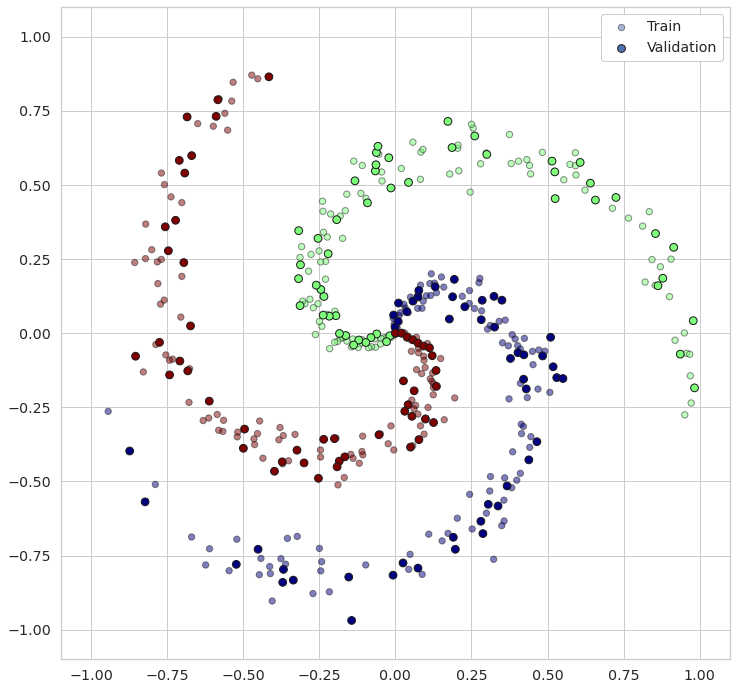

In [8]:
plt.figure(figsize=(12, 12))
plt.scatter(X_train[:, 0], X_train[:, 1], s=40, 
            c=y_train, cmap="jet", edgecolors="k", alpha=0.5, 
            label="Train")
plt.scatter(X_valid[:, 0], X_valid[:, 1], s=60, 
            c=y_valid, cmap="jet", edgecolors="k", 
            label="Validation")
plt.xlim([-1.1, 1.1])
plt.ylim([-1.1, 1.1])
plt.legend();

# Модели

## Бейзлайн: Sklearn Логистическая Регрессия

Чтобы иметь значение качества, от которого дальше можно отталкиваться в сравнении моделей, принято сначала делать самую простую базовую модель. Ее называют бейзлайн (baseline). Здесь в качестве бейзлайна мы возьмем линейную модель классификации из библиотеки Sklearn.

Заметим, что хоть модель и названа **логистическая регрессия**, она решает задачу **классификации**. Ошибки здесь нет.

In [9]:
model_lr_sklearn = LogisticRegression(C = 1e8, 
                                      max_iter=200, 
                                      solver="sag", 
                                      multi_class="multinomial")

Тренируем модель

In [10]:
model_lr_sklearn.fit(X_train, y_train)

LogisticRegression(C=100000000.0, max_iter=200, multi_class='multinomial',
                   solver='sag')

Оцениваем качество

In [11]:
print("Train accuracy: {:.1f}%".format(model_lr_sklearn.score(X_train, y_train) * 100))
print("Valid accuracy: {:.1f}%".format(model_lr_sklearn.score(X_valid, y_valid) * 100))

Train accuracy: 52.3%
Valid accuracy: 53.3%


Рисуем получившуюся разделяющую поверхность

In [12]:
def plot_model(model, X, y, val_data=None):
    # get limits
    x_min, x_max = X[:, 0].min() * 1.1, X[:, 0].max() * 1.1
    y_min, y_max = X[:, 1].min() * 1.1, X[:, 1].max() * 1.1
    # generate mesh grid
    h = 0.02
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    # get model predictions
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # plot
    plt.figure(figsize=(12, 12))
    plt.contourf(xx, yy, Z, cmap="jet", alpha=0.1)
    if val_data is not None:
        X_valid, y_valid = val_data
        plt.scatter(X[:, 0], X[:, 1], s=40, 
                    c=y, cmap="jet", edgecolors="k", alpha=0.5, 
                    label="Train")
        plt.scatter(X_valid[:, 0], X_valid[:, 1], s=60, 
                    c=y_valid, cmap="jet", edgecolors="k", alpha=1.0, 
                    label="Validation")
    else:
        plt.scatter(X[:, 0], X[:, 1], s=40, 
                    c=y, cmap="jet", edgecolors="k", alpha=1.0, 
                    label="Train")
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.legend()

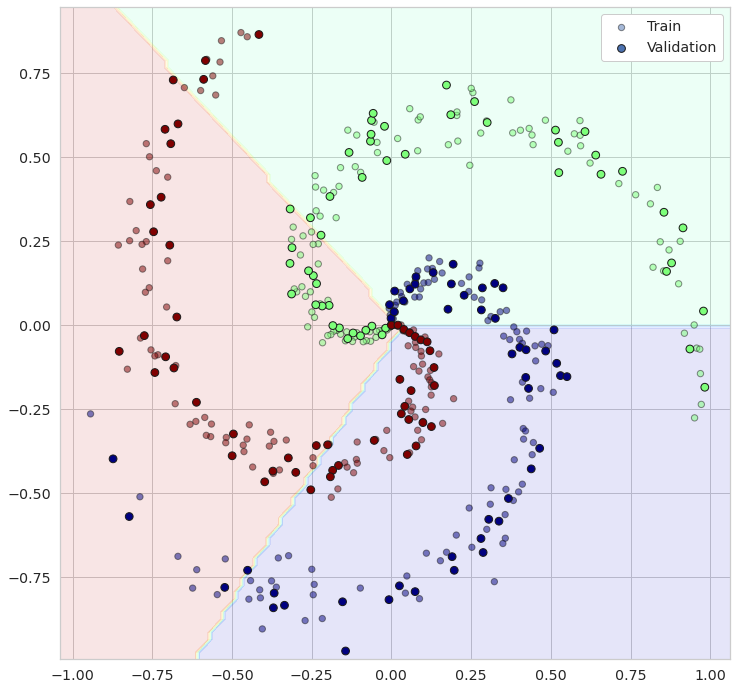

In [ ]:
plot_model(model_lr_sklearn, X_train, y_train, (X_valid, y_valid))

Линейный классификатор, как и ожадалось, не очень хорошо здесь работает.

## PyTorch

PyTorch требует свой собственный тип векторов, который называется тензор и немного отличается от формата в numpy

In [13]:
X_train_tensor = torch.tensor(np.array(X_train), dtype=torch.float)
X_valid_tensor = torch.tensor(np.array(X_valid), dtype=torch.float)

y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.long)

Также определим базовые константы из данных, чтобы использовать их в дальнейшем

In [14]:
n_data = len(X_train_tensor)

In [15]:
n_data

300

In [16]:
n_features

2

In [17]:
n_classes

3

Будем оценивать нашу модель по двум метрикам:
* CCE (Categorical Cross Entropy)
* Accuracy

In [18]:
def accuracy_loss(input, target):
    return torch.mean((np.argmax(input, axis=1) == target).type(torch.float)) * 100

Также определим функцию ошибки, в соответствии с которой мы будем обучать модель. В нашем случае это CCE.

In [19]:
loss_func = nn.CrossEntropyLoss()

Зададим набор метрик, которые хотим отслеживать

In [20]:
metrics_func = [loss_func, accuracy_loss]
metrics_name = ["CCE", "Accuracy"]

Определим функцию для оценки качества одной модели на заданном датасете по заданным метрикам

In [21]:
def evaluate(model, metrics_func, X, y):
    metrics_value = []
    with torch.no_grad():
        preds = model(X)
        for metric_func in metrics_func:
            metric_value = metric_func(preds, y)
            metrics_value.append(metric_value)
    return metrics_value

Утилита для визуализации разделяющей поверхности для моделей PyTorch

In [22]:
def plot_model_pytorch(model, X, y, val_data=None):

    class ModelClfPredictor(object):

        def __init__(self, model_clf_pytorch):
            self._model = model_clf_pytorch

        def predict(self, X):
            with torch.no_grad():
                preds = self._model(torch.FloatTensor(X))
            return np.argmax(np.array(preds), axis=1)
    
    _temp = ModelClfPredictor(model)
    plot_model(_temp, X, y, val_data)

### Логистическая регрессия

Модель "Логистическая регрессия" можно рассматривать как простую нейронную сеть без скрытых слоев и без функций активации

Количество признаков в нашем датасете Spirals 2. Поэтому входной слой имеет 2 нейрона. Предсказывать мы хотим номер класса, которому принадлежит объект. Всего у нас 3 класса. Поэтому будет 3 выходных нейрона - каждый нейрон показывает вероятность принадлежности каждому из классов. В итоге объект будет принадлежать тому классу, чья вероятность больше.

In [23]:
model_lr = nn.Sequential(
    nn.Linear(in_features=n_features, out_features=n_classes),
)

Для обучения мы будем использовать простейший градиентный метод пошаговой оптимизации - Batch Gradient Descent.

In [24]:
opt_lr = optim.SGD(params=model_lr.parameters(), lr=0.01)
batch_size_lr = 16

Тренируем модель

In [25]:
%%time

epochs_lr = 1500
history_lr_train = []
history_lr_valid = []

for epoch in tqdm(range(epochs_lr)):
    for i in range((n_data - 1) // batch_size_lr + 1):

        # формирование батча данных
        start_i = i * batch_size_lr
        end_i = start_i + batch_size_lr
        Xb = X_train_tensor[start_i:end_i]
        yb = y_train_tensor[start_i:end_i]
        
        # forward pass: делаем предсказания
        pred = model_lr(Xb)
        # forward pass: считаем ошибку
        loss = loss_func(pred, yb)

        # backward pass: считаем градиенты
        loss.backward()

        # обновление весов
        opt_lr.step()
        opt_lr.zero_grad()
    
    history_lr_train.append(evaluate(model_lr, metrics_func, X_train_tensor, y_train_tensor))
    history_lr_valid.append(evaluate(model_lr, metrics_func, X_valid_tensor, y_valid_tensor))

history_lr_train = np.array(history_lr_train)
history_lr_valid = np.array(history_lr_valid)

  0%|          | 0/1500 [00:00<?, ?it/s]

CPU times: user 11.1 s, sys: 124 ms, total: 11.2 s
Wall time: 11.5 s


Нарисуем как менялась функция ошибки по ходу обучения

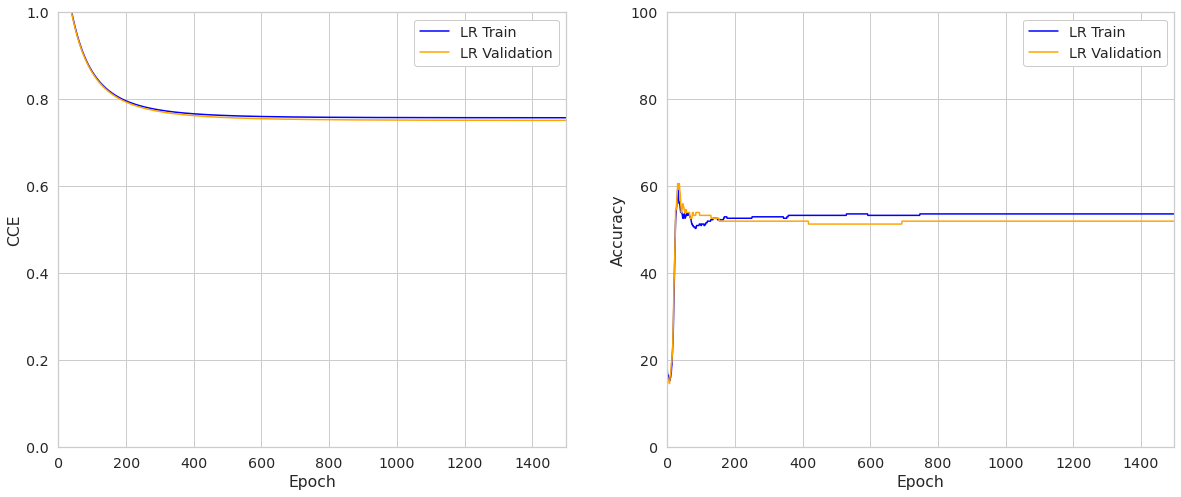

In [26]:
plt.figure(figsize=(20, 8))

plt.subplot(121)
plt.plot(history_lr_train[:, 0], label="LR Train", color="blue")
plt.plot(history_lr_valid[:, 0], label="LR Validation", color="orange")
plt.legend(frameon=True)
plt.ylim([0, 1])
plt.xlim([0, epochs_lr - 1])
plt.ylabel("CCE")
plt.xlabel("Epoch");

plt.subplot(122)
plt.plot(history_lr_train[:, 1], label="LR Train", color="blue")
plt.plot(history_lr_valid[:, 1], label="LR Validation", color="orange")
plt.legend(frameon=True)
plt.ylim([0, 100])
plt.xlim([0, epochs_lr - 1])
plt.ylabel("Accuracy")
plt.xlabel("Epoch");

Рисуем получившуюся разделяющую поверхность

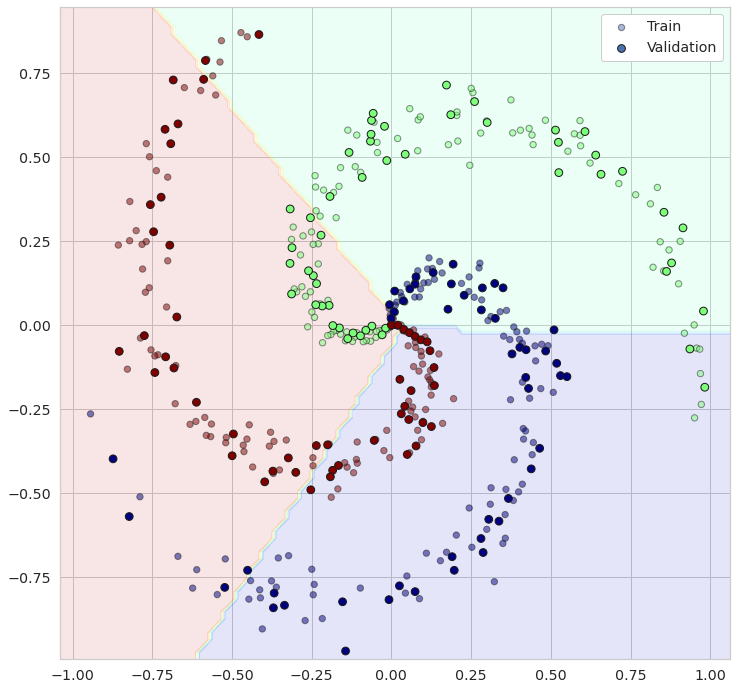

In [27]:
plot_model_pytorch(model_lr, X_train, y_train, (X_valid, y_valid))

###Задание: MLP с 3 скрытыми слоями

Теперь определим более сложную модель с 3 скрытыми слоями и ReLU функцией активации.

![relu image](https://analyticsindiamag.com/wp-content/uploads/2018/01/relu-activation-function-1.png)

Наша задача - создать нейросеть со следующей архитектурой

* Первый скрытый слой - 16 нейронов
* Функция активации - ReLU
* Второй скрытый слой - 32 нейрона
* Функция активации - ReLU
* Третий скрытый слой - 32 нейрона
* Функция активации - ReLU



Сеттинг для обучения такой же как и раньше.

In [28]:
model_mlp_3 = nn.Sequential(
    nn.Linear(in_features=n_features, out_features=16),
    nn.ReLU(),
    nn.Linear(in_features=16, out_features=32),
    nn.ReLU(),
    nn.Linear(in_features=32, out_features=32),
    nn.ReLU(),
    nn.Linear(in_features=32, out_features=n_classes)
)

In [ ]:
opt_mlp_3 = optim.SGD(params=model_mlp_3.parameters(), lr=0.01)
batch_size_mlp_3 = 16

Тренируем модель

In [ ]:
%%time

epochs_mlp_3 = 1500
history_mlp_3_train = []
history_mlp_3_valid = []

for epoch in tqdm(range(epochs_mlp_3)):
    for i in range((n_data - 1) // batch_size_mlp_3 + 1):

        # формирование батча данных
        start_i = i * batch_size_mlp_3
        end_i = start_i + batch_size_mlp_3
        Xb = X_train_tensor[start_i:end_i]
        yb = y_train_tensor[start_i:end_i]
        
        # forward pass: делаем предсказания
        pred = model_mlp_3(Xb)
        # forward pass: считаем ошибку
        loss = loss_func(pred, yb)

        # backward pass: считаем градиенты
        loss.backward()

        # обновление весов
        opt_mlp_3.step()
        opt_mlp_3.zero_grad()
    
    history_mlp_3_train.append(evaluate(model_mlp_3, metrics_func, X_train_tensor, y_train_tensor))
    history_mlp_3_valid.append(evaluate(model_mlp_3, metrics_func, X_valid_tensor, y_valid_tensor))

history_mlp_3_train = np.array(history_mlp_3_train)
history_mlp_3_valid = np.array(history_mlp_3_valid)

  0%|          | 0/1500 [00:00<?, ?it/s]

CPU times: user 18.7 s, sys: 172 ms, total: 18.9 s
Wall time: 18.9 s


Нарисуем как менялась функция ошибки по ходу обучения и сравним это с предыдущей моделью (PyTorch Logistic Regression)

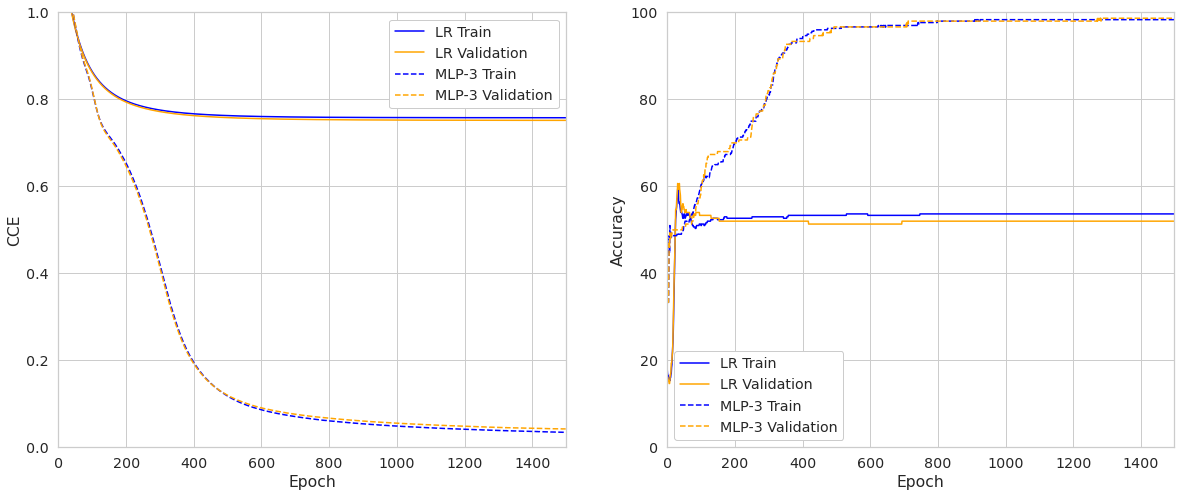

In [ ]:
plt.figure(figsize=(20, 8))

plt.subplot(121)
plt.plot(history_lr_train[:, 0], label="LR Train", color="blue")
plt.plot(history_lr_valid[:, 0], label="LR Validation", color="orange")
plt.plot(history_mlp_3_train[:, 0], label="MLP-3 Train", color="blue", linestyle="--")
plt.plot(history_mlp_3_valid[:, 0], label="MLP-3 Validation", color="orange", linestyle="--")
plt.legend(frameon=True)
plt.ylim([0, 1])
plt.xlim([0, epochs_mlp_3 - 1])
plt.ylabel("CCE")
plt.xlabel("Epoch");

plt.subplot(122)
plt.plot(history_lr_train[:, 1], label="LR Train", color="blue")
plt.plot(history_lr_valid[:, 1], label="LR Validation", color="orange")
plt.plot(history_mlp_3_train[:, 1], label="MLP-3 Train", color="blue", linestyle="--")
plt.plot(history_mlp_3_valid[:, 1], label="MLP-3 Validation", color="orange", linestyle="--")
plt.legend(frameon=True)
plt.ylim([0, 100])
plt.xlim([0, epochs_mlp_3 - 1])
plt.ylabel("Accuracy")
plt.xlabel("Epoch");

Рисуем получившуюся разделяющую поверхность

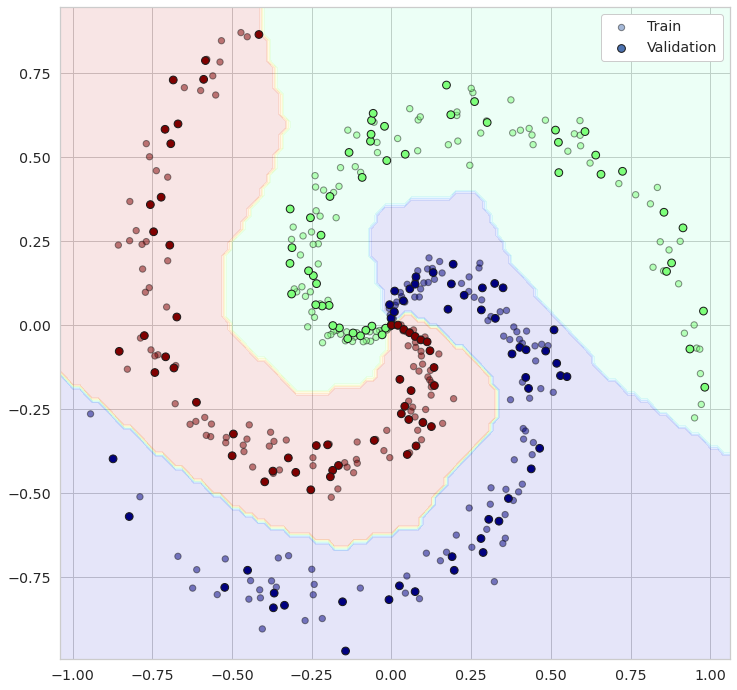

In [ ]:
plot_model_pytorch(model_mlp_3, X_train, y_train, (X_valid, y_valid))